In [1]:
import awkward as ak
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [2]:
# Load 10k events from 2018 signal
fname = "root://xrootd.cmsaf.mit.edu:1094///store/mc/RunIISummer20UL18NanoAODv9/GluGluToHHTo4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2810000/2207F5D6-4518-F44A-8C92-68E712CAF67C.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema, entry_stop=10000).events()

In [3]:
events

<NanoEventsArray [<event 1:34:33001>, ... ] type='10000 * event'>

In [4]:
events.fields

['SoftActivityJetNjets10',
 'GenDressedLepton',
 'PSWeight',
 'fixedGridRhoFastjetAll',
 'GenPart',
 'HTXS',
 'LHEReweightingWeight',
 'PV',
 'FsrPhoton',
 'fixedGridRhoFastjetCentralCalo',
 'HLT',
 'run',
 'fixedGridRhoFastjetCentral',
 'DeepMETResolutionTune',
 'ChsMET',
 'SubJet',
 'Generator',
 'SoftActivityJetHT',
 'MET',
 'TrigObj',
 'SV',
 'Electron',
 'RawMET',
 'LHEPart',
 'L1simulation',
 'SoftActivityJetHT5',
 'GenVisTau',
 'LHE',
 'genWeight',
 'PuppiMET',
 'LowPtElectron',
 'Muon',
 'RawPuppiMET',
 'genTtbarId',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'HLTriggerFirstPath',
 'GenJet',
 'boostedTau',
 'CorrT1METJet',
 'HLTriggerFinalPath',
 'DeepMETResponseTune',
 'SubGenJetAK8',
 'L1Reco',
 'event',
 'Flag',
 'luminosityBlock',
 'TkMET',
 'SoftActivityJetNjets2',
 'Photon',
 'CaloMET',
 'Tau',
 'LHEWeight',
 'IsoTrack',
 'FatJet',
 'SoftActivityJetNjets5',
 'SoftActivityJetHT2',
 'GenMET',
 'GenIsolatedPhoton',
 'Jet',
 'fixedGridRhoFastjetCentralNeutral',
 'LHEScaleWe

## Reproducing selections from matching skimmer

The following code tries to reproduce the steps followed in the processor ("matchingSkimmer")
https://github.com/LPC-HH/HH4b/blob/aa89287b612b5fb62d95b827ff79c9e1854ac8dd/src/HH4b/processors/matchingSkimmer.py

In [5]:
from processors.objects import *
from processors.utils import P4, pad_val


year = "2018"
isData = not hasattr(events, "genWeight")

num_jets = 6
jets = good_ak4jets(events.Jet, year, events.run.to_numpy(), isData)
# sort by b-tagging score
jets = jets[ak.argsort(jets.btagDeepFlavB, ascending=False)]

# vbf jets
vbf_jets = jets[(jets.pt > 25) & (((jets.pt < 50) & (jets.puId >= 6)) | (jets.pt >= 50))]

# jets p4 corrected by bjet energy regression
jets_p4 = bregcorr(jets)

num_fatjets = 3
fatjets = good_ak8jets(events.FatJet)
# sort by bb
fatjets = fatjets[ak.argsort(fatjets.Txbb, ascending=False)]

veto_muon_sel = good_muons(events.Muon, selection=veto_muon_selection_run2_bbbb)
veto_electron_sel = good_electrons(events.Electron, selection=veto_electron_selection_run2_bbbb)

ak4JetVars = {
    **{
        f"ak4Jet{key}": pad_val(getattr(jets_p4, var), num_jets, axis=1)
        for (var, key) in P4.items()
    },
}

Now copy the function that will do the jet assignment

In [6]:
import vector
import itertools

vector.register_awkward()

method = "dhh"

# compute possible jet assignments lookup table
MIN_JETS = 4
MAX_JETS = 4
HIGGS_MASS = 125.0
JET_ASSIGNMENTS = {}
for nj in range(MIN_JETS, MAX_JETS + 1):
    a = list(itertools.combinations(range(nj), 2))
    b = np.array([(i, j) for i, j in itertools.combinations(a, 2) if len(set(i + j)) == MIN_JETS])
    JET_ASSIGNMENTS[nj] = b

# just consider top 4 jets (already sorted by b-jet score)
nj = 4
jets = vector.array(
    {
        "pt": ak4JetVars["ak4JetPt"],
        "eta": ak4JetVars["ak4JetEta"],
        "phi": ak4JetVars["ak4JetPhi"],
        "M": ak4JetVars["ak4JetMass"],
    },
)

# get array of dijets for each possible higgs combination
jj = jets[:, JET_ASSIGNMENTS[nj][:, :, 0]] + jets[:, JET_ASSIGNMENTS[nj][:, :, 1]]
mjj = jj.M

if method == "chi2":
    chi2 = ak.sum(np.square(mjj - HIGGS_MASS), axis=-1)
    index = ak.argmin(chi2, axis=-1)
elif method == "dhh":
    # https://github.com/UF-HH/bbbbAnalysis/blob/master/src/OfflineProducerHelper.cc#L4109
    mjj_sorted = ak.sort(mjj, ascending=False)

    # compute \delta d
    k = 125 / 120
    delta_d = np.absolute(mjj_sorted[:, :, 0] - k * mjj_sorted[:, :, 1]) / np.sqrt(1 + k**2)

    # take combination with smallest distance to the diagonal
    index_mindhh = ak.argmin(delta_d, axis=-1)

    # except, if |dhh^1 - dhh^2| < 30 GeV
    # this is when the pairing method starts to make mistakes
    d_sorted = ak.sort(delta_d, ascending=False)
    is_dhh_tooclose = (d_sorted[:, 0] - d_sorted[:, 1]) < 30

    # order dijets with the highest sum pt in their own event CoM frame
    # CoM frame of dijets
    cm = jj[:, :, 0] + jj[:, :, 1]
    com_pt = jj[:, :, 0].boostCM_of(cm).pt + jj[:, :, 1].boostCM_of(cm).pt
    index_max_com_pt = ak.argmax(com_pt, axis=-1)

    index = ak.where(is_dhh_tooclose, index_max_com_pt, index_mindhh)

    # TODO: is there an exception if the index chosen is the same?
    # is_same_index = (index == index_max_com_pt)

print("Jet assignments resulting from pairing algorithm ")
print(JET_ASSIGNMENTS[nj][index][:, 0, :])

# now get the resulting bb pairs
# best comb index for each event
first_bb_pair = JET_ASSIGNMENTS[nj][index][:, 0, :]
first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_pair = JET_ASSIGNMENTS[nj][index][:, 1, :]
second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

# TODO: sort by dijet pt
# TODO: not sure what the best way to do this is..
# perhaps using ak.concatenate?
bb_pairs = np.stack([first_bb_pair, second_bb_pair], axis=1)

bbs_jjpt = np.concatenate([first_bb_dijet.pt.reshape(-1,1), second_bb_dijet.pt.reshape(-1,1)], axis=1)
sort_by_jjpt = np.argsort(bbs_jjpt, axis=-1)[:,::-1]

bb_pairs_sorted = np.array([ [bb_pair_e[sort_e[0]], bb_pair_e[sort_e[1]]] for bb_pair_e, sort_e in zip(bb_pairs, sort_by_jjpt)])

first_bb_pair_sort = bb_pairs_sorted[:,0]
second_bb_pair_sort = bb_pairs_sorted[:,1]

first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

jetAssignmentDict = {
    "ak4DijetPt0": first_bb_dijet.pt,
    "ak4DijetEta0": first_bb_dijet.eta,
    "ak4DijetPhi0": first_bb_dijet.phi,
    "ak4DijetMass0": first_bb_dijet.mass,
    "ak4DijetPt1": second_bb_dijet.pt,
    "ak4DijetEta1": second_bb_dijet.eta,
    "ak4DijetPhi1": second_bb_dijet.phi,
    "ak4DijetMass1": second_bb_dijet.mass,
    "ak4DijetDeltaR": first_bb_dijet.deltaR(second_bb_dijet),
}

Jet assignments resulting from pairing algorithm 
[[0 3]
 [0 3]
 [0 3]
 ...
 [0 2]
 [0 2]
 [0 3]]


In [7]:
import matplotlib.pyplot as plt
import hist

dijet_mass_axis = hist.axis.Regular(20, 60, 200, name="dijet_mass", label="Dijet Mass [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_mass_axis, pair_axis)
h.fill(dijet_mass=jetAssignmentDict["ak4DijetMass0"], pair="0")
h.fill(dijet_mass=jetAssignmentDict["ak4DijetMass1"], pair="1")

Hist(
  Regular(20, 60, 200, name='dijet_mass', label='Dijet Mass [GeV]'),
  StrCategory(['0', '1'], growth=True, name='pair'),
  storage=Double()) # Sum: 15406.0 (20000.0 with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f254f665940>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

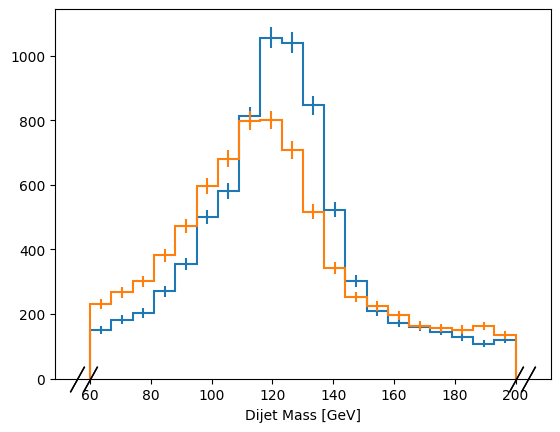

In [8]:
import mplhep

mplhep.histplot(h[{"pair": "0"}])
mplhep.histplot(h[{"pair": "1"}])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f254c666100>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

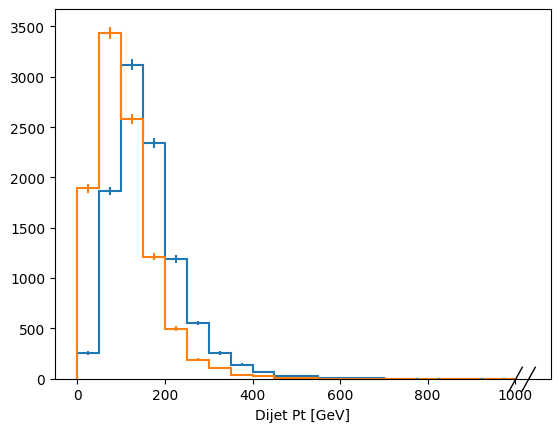

In [9]:
dijet_pt_axis = hist.axis.Regular(20, 0, 1000, name="dijet_pt", label="Dijet Pt [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_pt_axis, pair_axis)
h.fill(dijet_pt=jetAssignmentDict["ak4DijetPt0"], pair="0")
h.fill(dijet_pt=jetAssignmentDict["ak4DijetPt1"], pair="1")

mplhep.histplot(h[{"pair": "0"}])
mplhep.histplot(h[{"pair": "1"}])

In [10]:
jetAssignmentDict["ak4DijetPt0"]

array([121.12994839,  52.54989542,  85.45180898, ..., 130.62165802,
       105.71452172, 132.26739094])

In [11]:
jetAssignmentDict["ak4DijetPt1"]

array([ 18.08726126,  51.7334611 ,  23.73286696, ...,  24.08015168,
        95.43987159, 130.40055885])

In [12]:
jetAssignmentDict["ak4DijetDeltaR"]

array([1.21828924, 7.08352325, 5.91422441, ..., 1.98211621, 3.35686714,
       2.89492679])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f254c63d700>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

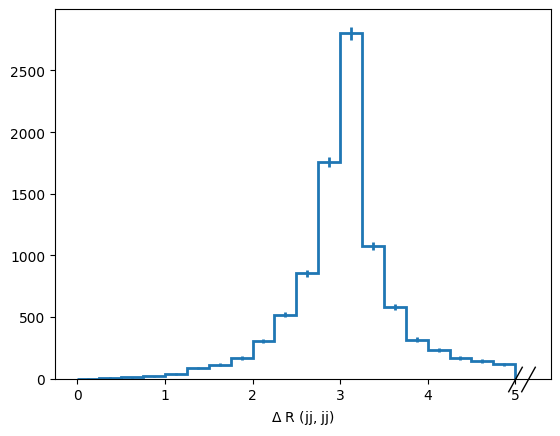

In [13]:
deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, jj)")

h = hist.Hist(deltar_axis)
h.fill(deltar=jetAssignmentDict["ak4DijetDeltaR"])

h.plot1d(lw=2)

## Next steps
1. Change code so that  `first_bb_dijet` and `second_bb_dijet` are actually the dijet with leading pt and second leading pt respectively (right now, they are most of the time but not always)
2. Compare mass reconstruction with chi2 and dhh method